In [1]:
import seaborn as sns

sns.set_theme(
    rc={"axes.spines.top": False, "axes.spines.right": False, "figure.autolayout": True},
    style="ticks",
)

# Plotting simulations & residuals spectra

Simulations and data as well as covariance are stored as `sacc` objects. For more details regarding `sacc` format, you can have a look to the tutorial [notebooks](https://github.com/LSSTDESC/sacc/tree/master/examples) or you can refer to the official [documentation](https://sacc.readthedocs.io/en/latest/). Here we will read the power spectra for all the simulations and compare its mean value to theory + foregrounds (without and with systematics). As we will see, **the content of each spectrum (multipole range, spectra, associated covariance...) is stored within the `spec_meta` attribute of `MFLike`**. In this tutorial, we will see how to dig into this attribute to plot simulated data against models.


We first start by using the likelihood declaration from the first [tutorial](tutorial_loading.ipynb)

In [2]:
%run tutorial_loading.ipynb

     Numpy : 1.26.4
Matplotlib : 3.8.3
      CAMB : 1.5.4
    Cobaya : 3.5
[install] Installing external packages at '/tmp/LAT_packages'

likelihood:mflike.MFLike

[install] Checking if dependencies have already been installed...
[install] External dependencies for this component already installed.
[install] Doing nothing.

* Summary * 

[install] All requested components' dependencies correctly installed at /tmp/LAT_packages
[camb] `camb` module loaded successfully from /home/garrido/Workdir/cmb/development/LAT_MFLike/pyenv/lib/python3.11/site-packages/camb
[mflike.mflike] Number of bins used: 3087
[mflike.mflike] Initialized!


As we did in the foreground [tutorial](tutorial_foregrounds.ipynb), we first get the theory spectra

In [3]:
model.logposterior({})
dls = model.theory["camb"].get_Cl(ell_factor=True)

[mflike.mflike] Computing bandpass at first step, no shifts


To take into account the systematics, we call the `mflike.get_modified_theory` function. In this function, we need to use the same $\ell$ range set by the data through the variable `l_bpws`, that is why we generated the theory spectra using the `mflike.l_bpws` ell range. (Notice that `dls` has a multipole range of `2, mflike.l_bpws[-1]`).

In [4]:
ell = mflike.l_bpws
dls_cmb = {mode: dls[mode][ell] for mode in ["tt", "te", "ee", "bb"]}
foreground_model = model.theory["mflike.BandpowerForeground"]
fg_totals = foreground_model.get_fg_totals()
dl_obs = mflike.get_modified_theory(dls_cmb, fg_totals, **nuisance_params)

There would be a difference between theory, foreground and the total spectra modified by the systematics once some of the `nuisance_parameters` are set to a non-ideal value.

## Simulated data *vs.* data model

We start by plotting unbinned theory + foreground model with the total power spectrum modified by the systematics for a bunch of simulated files. Let's first start by retrieving the foreground model as a dictionary

In [5]:
fg_models = foreground_model.get_foreground_model(ell=ell, **fg_params)

To load `MFLike` for different simulated data file, we will use the external way as described in the last part of this [tutorial](tutorial_logp_value.ipynb). Altough the `spec_meta` attribute holds the different spectra, there is no easy way to extract a specific cross and/or mode. Here we will built a dictionary indexed on spectrum mode and cross experiments to be latter used by the plotting function (the `contextmanager` is just to catch and flush the `logging` messages when initializing `MFLike` likelihood)

In [6]:
import logging
from contextlib import contextmanager

from mflike import MFLike_TTTEEE
from tqdm.auto import tqdm


@contextmanager
def disable_logging(highest_level=logging.CRITICAL):
    previous_level = logging.root.manager.disable
    logging.disable(highest_level)
    try:
        yield
    finally:
        logging.disable(previous_level)


nsims = 10
dls_sims = {}
for isim in tqdm(range(nsims)):
    input_file = dict(input_file=f"LAT_simu_sacc_{isim:05d}.fits")
    with disable_logging():
        ext_mflike = MFLike_TTTEEE(mflike_input_file | input_file, packages_path=packages_path)
        for data in ext_mflike.spec_meta:
            lb, db = data.get("leff"), data.get("cl_data")
            cross = (data.get("t1"), data.get("t2"))
            mode = data.get("pol") if not data.get("hasYX_xsp") else "et"
            dls_sims.setdefault((mode, *cross), []).append([lb, db])

  0%|          | 0/10 [00:00<?, ?it/s]

Finally, we can plot the different simulated spectra on top of the CMB expectation + the foreground model

In [7]:
import matplotlib.pyplot as plt


def plot_simulation(*cross):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    for mode, ax in zip(["tt", "ee", "te", "et"], axes.flatten()):
        if not (dls_sim := dls_sims.get((mode, *cross))):
            fig.delaxes(ax)
            continue
        ax.legend([], title="{} - {}x{}".format(mode.upper(), *cross))
        if mode == "tt":
            ax.set(yscale="log", ylim=(0.1, 10_000))

        mode = "te" if mode == "et" else mode
        for lb, db in dls_sim:
            ax.plot(lb, db, "gray")
        ax.plot(ell, dls_cmb[mode], "-r", label="theory")
        ax.plot(ell, fg_models[mode, "all", *cross], "-b", label="all foregrounds")
        ax.plot(ell, dl_obs[mode, *cross], "-g", lw=2, label="theory + FG with systematics")
        ax.plot(*np.mean(dls_sim, axis=0), "--k", label="mean sim.")

    fig.supxlabel(r"$\ell$")
    fig.supylabel(r"$D_\ell$")
    fig.legend(*axes[0, 0].get_legend_handles_labels(), bbox_to_anchor=(1.3, 1));

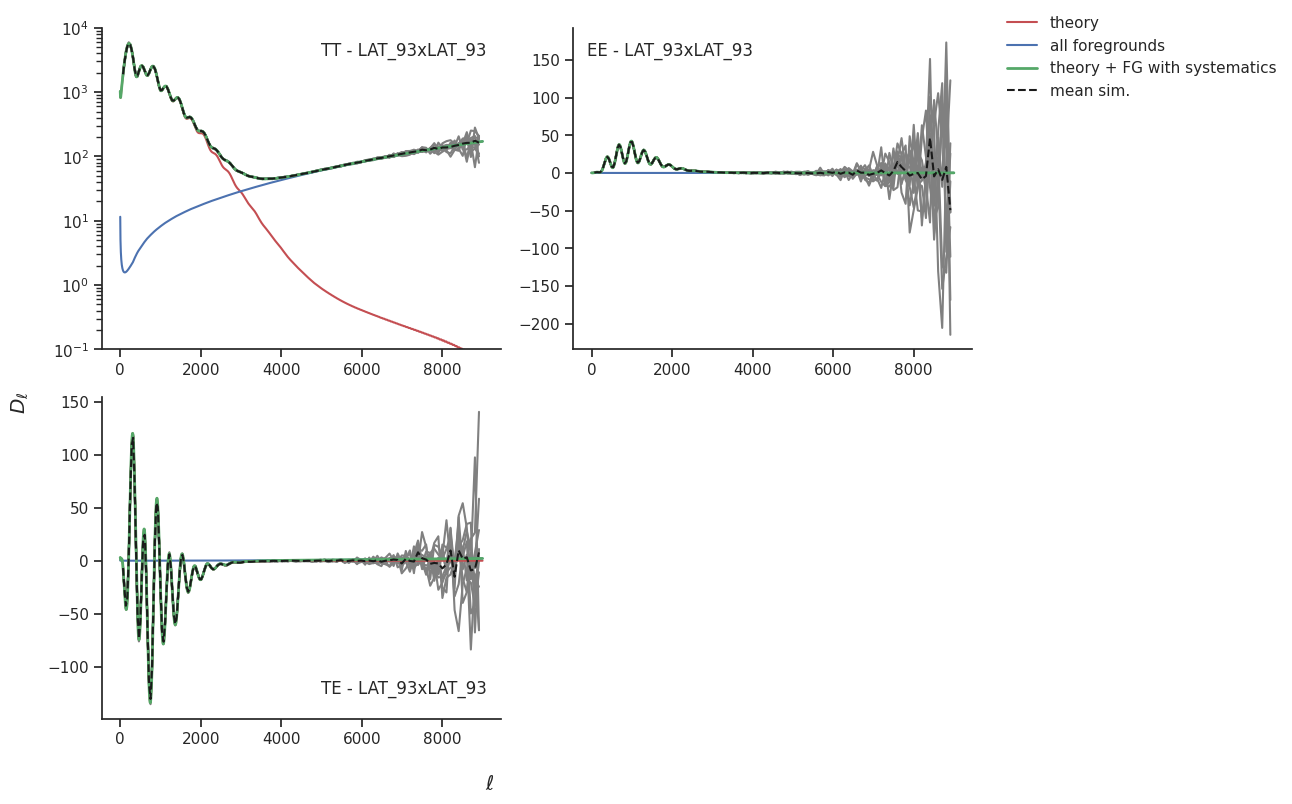

In [8]:
plot_simulation("LAT_93", "LAT_93")

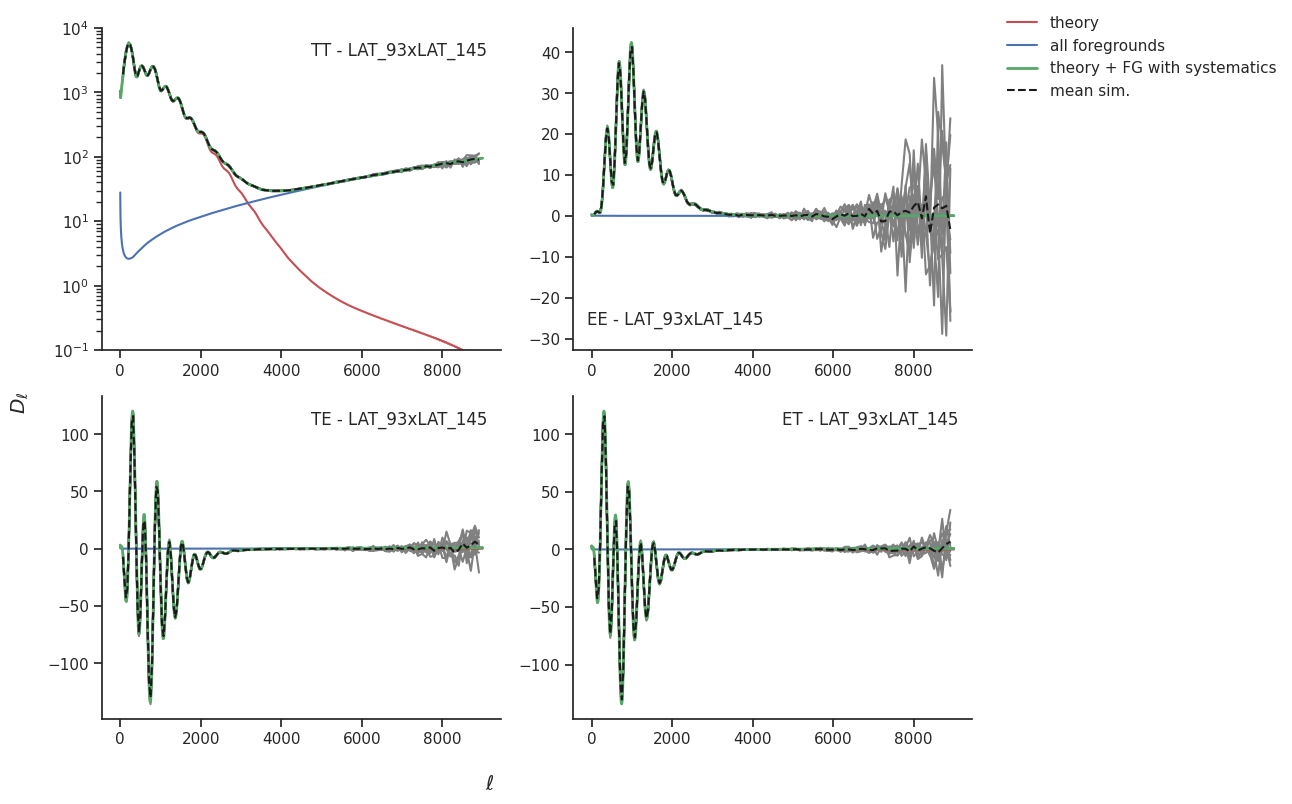

In [9]:
plot_simulation("LAT_93", "LAT_145")

## Plotting residuals

Given a simulation file, we will loop over the content of `MFLike.spec_meta` attribute to plot the residuals *i.e.* simulations - (theory + foregrounds with possible systematics) for the different spectra and cross frequencies. The bandpower weights are stored within the `bpw` field of `spec_meta` and we use it to bin the theory and foregrounds spectra

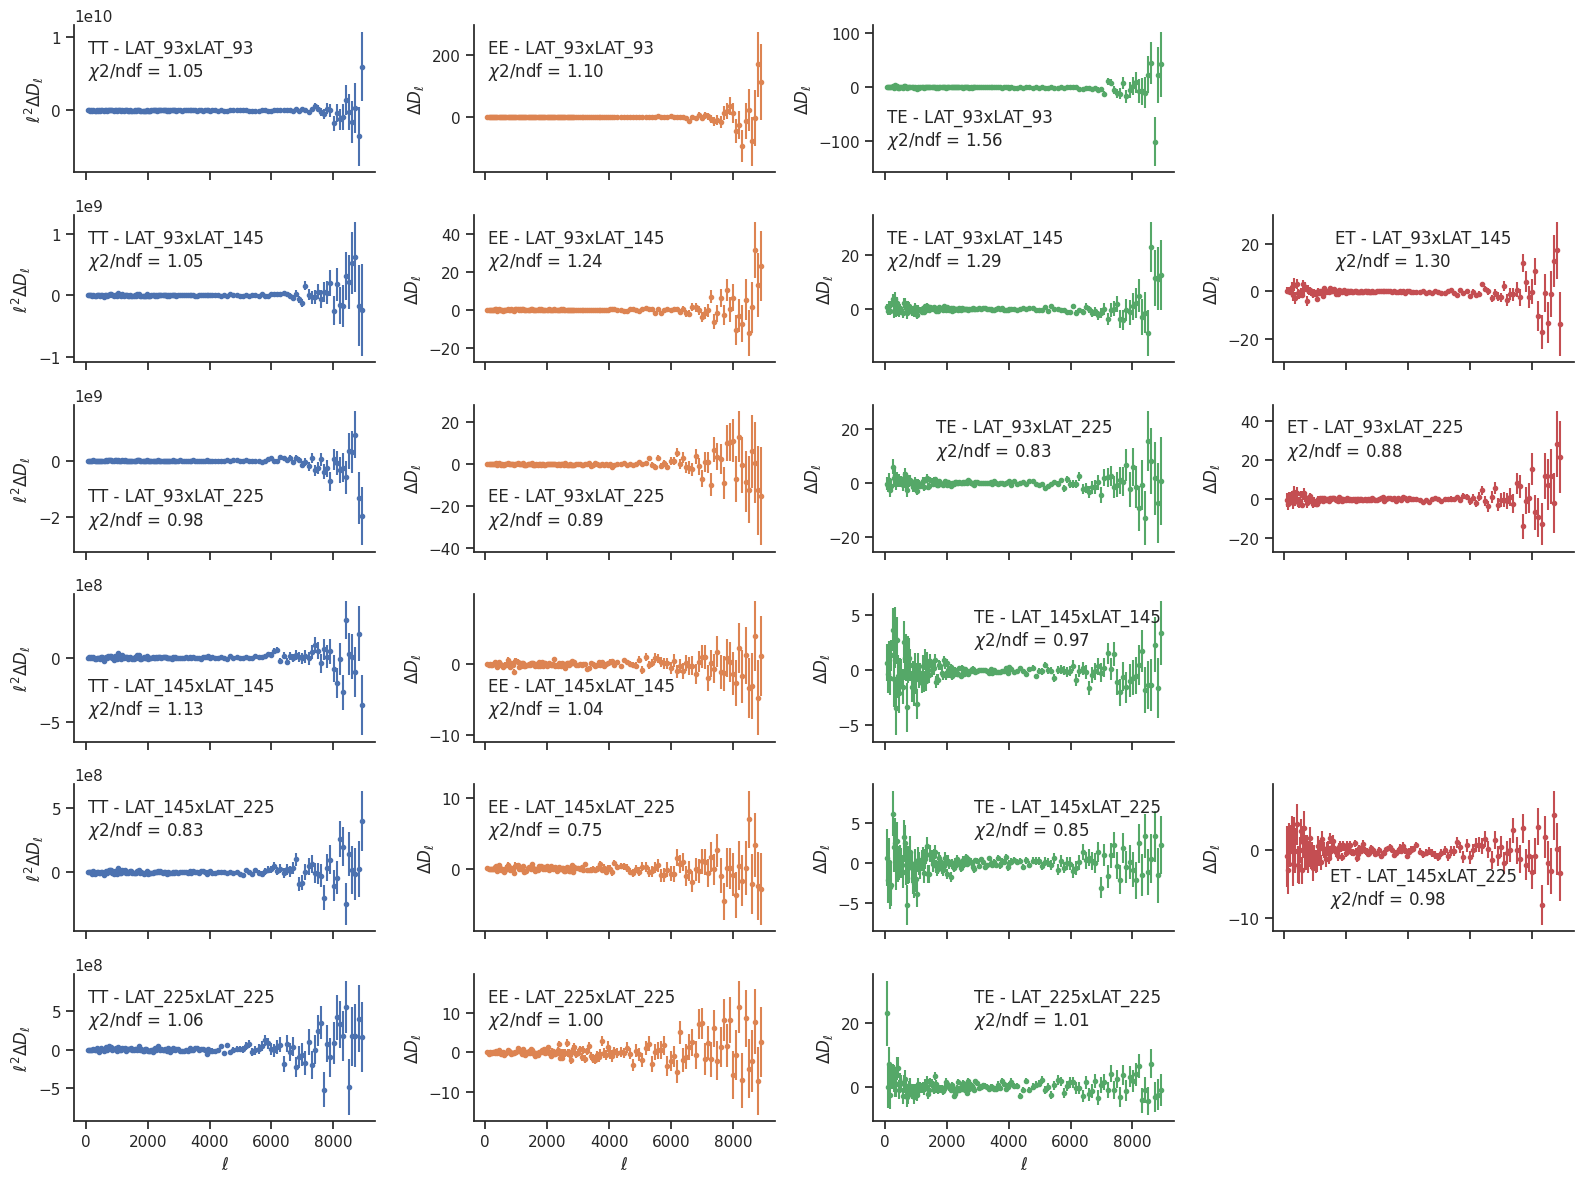

In [10]:
from itertools import combinations_with_replacement as cwr

modes = ["tt", "ee", "te", "et"]

experiments = mflike.experiments
crosses = list(cwr(experiments, 2))
fig, axes = plt.subplots(len(crosses), 4, sharex=True, figsize=(16, 2 * len(crosses)))

for data in mflike.spec_meta:

    # Data/simulation
    lb = data.get("leff")
    db = data.get("cl_data")
    ids = data.get("ids")
    cov = mflike.cov[np.ix_(ids, ids)]
    db_err = np.sqrt(np.diag(cov))

    # Fit
    cross = (data.get("t1"), data.get("t2"))
    db_fit = dl_obs[data.get("pol"), *cross] @ data["bpw"].weight
    delta_db = db - db_fit

    irow = crosses.index(cross)
    mode = data.get("pol") if not data.get("hasYX_xsp") else "et"
    icol = modes.index(mode)
    ax = axes[irow, icol]
    if mode == "tt":
        ax.errorbar(lb, lb**2 * delta_db, lb**2 * db_err, fmt=f".C{icol}")
    else:
        ax.errorbar(lb, delta_db, db_err, fmt=f".C{icol}")

    chi2 = delta_db @ np.linalg.inv(cov) @ delta_db
    title = "{} - {}x{}\n$\chi2$/ndf = {:.2f}".format(mode.upper(), *cross, chi2 / len(delta_db))
    ax.legend([], title=title)

# Remove empty axes
for ax in axes.flatten():
    if not ax.lines:
        fig.delaxes(ax)
for ax in axes[:, 0]:
    ax.set_ylabel(r"$\ell^2\Delta D_\ell$")
for ax in axes[:, 1:].flatten():
    ax.set_ylabel(r"$\Delta D_\ell$")
for ax in axes[-1]:
    ax.set_xlabel(r"$\ell$")

Notice that here the difference between simulations and the (theory+foreground) spectra with possible systematics is mainly driven by the different foreground model adopted by the code